In [75]:
using JLD2
using NCDatasets, Glob
using LinearAlgebra, Statistics
using Plots
using PACE_SIF
using LegendrePolynomials

In [76]:
# load params
params_file = "/home/zhe2/data/MyProjects/PACE_redSIF_PACE/retrieval_from_realData/20250927/retrieval_params_20250927.jld2"
@load params_file params

nSIF  = params.nSIF;
nPoly = params.nPoly;
nPC   = params.nPC;
SIF_shape = params.SIFComp[:, 1:nSIF];


┌ Warning: type Main.#10#20{Bool} does not exist in workspace; reconstructing
└ @ JLD2 /home/zhe2/.julia/packages/JLD2/wLPAN/src/data/reconstructing_datatypes.jl:620
┌ Warning: type BlockDiagonals.BlockDiagonal{Float64,Matrix{Float64}} does not exist in workspace; reconstructing
└ @ JLD2 /home/zhe2/.julia/packages/JLD2/wLPAN/src/data/reconstructing_datatypes.jl:620


In [103]:
# reconstruct
granule_code = "20250927T220954"
# load statevector
statevector_file = "SIF_$(granule_code)_*.nc";
dir   = "/home/zhe2/data/MyProjects/PACE_redSIF_PACE/retrieval_from_realData/20250927/";
recon = Dataset(first(glob(statevector_file, dir)), "r")["retrieved_state_vector"][:];
# SIF components
SIF_coeff = recon[:, :, nPoly+nPC+3:nPoly+nPC+nSIF+2];
# Replace missing with NaN before multiplication
SIF_coeff_clean = coalesce.(SIF_coeff, NaN)
SIF_shape_clean = coalesce.(SIF_shape, NaN)
# reconstruct SIF
SIF_reconstructed = mapslices(x -> x * SIF_shape_clean', SIF_coeff_clean, dims=[2,3])
# select wvlen
indx = findfirst(params.λ .> 681);
println("Selected wavelength: ", params.λ[indx], " nm")
# choose SIF 681 nm
SIF_681 = SIF_reconstructed[:, :, indx];

Selected wavelength: 681.9034 nm


In [78]:
# reference_nflh
nflh_file = "subset_PACE_OCI.$(granule_code).L2.OC_AOP.V3_1.nc";
nflh      = Dataset(first(glob(nflh_file, dir)), "r")["nflh"][:];


In [79]:
function reconstruct_components_1d(
    x::Vector, params::RetrievalParams; sza=nothing, E=nothing, Rtoa_obs=nothing, if_log=true
)
    nPoly = params.nPoly
    nPC = params.nPC
    nSIF = params.nSIF
    n_wavelengths = length(params.λ)

    # 1. Reflectance (Legendre polynomial expansion)
    λc = params.λc  # Central wavelength for normalization
    v = [collectPl(λ, lmax=nPoly) for λ in λc]  # Legendre polynomials
    ρ = hcat(v...)' * x[1:(nPoly + 1)]

    # 2. Transmittance
    trans_mat = params.PrinComp[:, 1:nPC]
    β = x[(nPoly + 2):(nPoly + nPC + 1)]

    if if_log
        logT₁ = trans_mat * β
        T₁ = exp.(-logT₁)
    else
        T₁ = trans_mat * β
    end

    # 3. Smoothing parameter and T₂
    smooth_x = 10.0 / (1.0 + exp(-x[nPoly + nPC + 2])) + 1.0

    if if_log
        T₂ = exp.(-smooth_x .* (trans_mat * β))
    else
        T₂ = exp.(smooth_x .* log.(T₁))
    end

    # 4. SIF
    SIF_shape = params.SIFComp[:, 1:nSIF]
    SIF_coeff = x[(nPoly + nPC + 3):(nPoly + nPC + nSIF + 2)]
    SIF = SIF_shape * SIF_coeff

    # 5. TOA Radiance (if angles provided)
    radiance = nothing
    if !isnothing(sza) && !isnothing(E)
        radiance = @. E * cosd(sza) / π * T₂ * ρ + SIF * T₁
    elseif !isnothing(params.E) && !isnothing(sza)
        radiance = @. params.E * cosd(sza) / π * T₂ * ρ + SIF * T₁
    end

    # 6. Residual (if Rtoa_obs provided)
    residual = nothing
    if !isnothing(Rtoa_obs) && !isnothing(radiance)
        residual = Rtoa_obs .- radiance
    end

    return Dict(
        "reflectance" => ρ,
        "T1" => T₁,
        "T2" => T₂,
        "SIF" => SIF,
        "radiance" => radiance,
        "residual" => residual,
        "smooth_param" => smooth_x,
        "beta" => β,
        "gamma" => x[1:(nPoly + 1)],
        "SIF_coeff" => SIF_coeff
    )
end


reconstruct_components_1d (generic function with 1 method)

In [80]:
function reconstruct_components_from_forward_model(
    state_vector::Array{Union{Missing, Float64}, 3}, params::RetrievalParams;
    sza=nothing, E=nothing, Rtoa_obs=nothing, if_log=true
) where T
    n_pixels, n_scans, n_state = size(state_vector)
    n_wavelengths = length(params.λ)

    # Pre-allocate
    results = Dict(
        "reflectance" => zeros(Float64, n_pixels, n_scans, n_wavelengths),
        "T1" => zeros(Float64, n_pixels, n_scans, n_wavelengths),
        "T2" => zeros(Float64, n_pixels, n_scans, n_wavelengths),
        "SIF" => zeros(Float64, n_pixels, n_scans, n_wavelengths),
        "radiance" => zeros(Float64, n_pixels, n_scans, n_wavelengths),
        "residual" => zeros(Float64, n_pixels, n_scans, n_wavelengths)
    )

    # Process each pixel
    for i in 1:n_pixels
        for j in 1:n_scans
            x = state_vector[i, j, :]

            # Skip invalid
            if any(ismissing, x) || any(isnan, x)
                results["reflectance"][i, j, :] .= NaN
                results["T1"][i, j, :] .= NaN
                results["T2"][i, j, :] .= NaN
                results["SIF"][i, j, :] .= NaN
                results["radiance"][i, j, :] .= NaN
                results["residual"][i, j, :] .= NaN
                continue
            end

            # Get angle and irradiance for this pixel
            sza_ij = !isnothing(sza) ? sza[i, j] : nothing
            Rtoa_obs_ij = !isnothing(Rtoa_obs) ? Rtoa_obs[i, j, :] : nothing

            # Reconstruct
            comp = reconstruct_components_1d(
                x, params, sza=sza_ij, E=E, if_log=if_log, Rtoa_obs=Rtoa_obs_ij
            )

            # Store
            results["reflectance"][i, j, :] = comp["reflectance"]
            results["T1"][i, j, :] = comp["T1"]
            results["T2"][i, j, :] = comp["T2"]
            results["SIF"][i, j, :] = comp["SIF"]

            if !isnothing(comp["radiance"])
                results["radiance"][i, j, :] = comp["radiance"]
            else
                results["radiance"][i, j, :] .= NaN
            end

            if !isnothing(comp["residual"])
                results["residual"][i, j, :] = comp["residual"]
            else
                results["residual"][i, j, :] .= NaN
            end
        end
    end

    return results
end


reconstruct_components_from_forward_model (generic function with 1 method)

In [81]:
statevector_file = "SIF_$(granule_code)_*.nc"
dir = "/home/zhe2/data/MyProjects/PACE_redSIF_PACE/retrieval_from_realData/20250927/"

# Load state vector
ds = Dataset(first(glob(statevector_file, dir)), "r")
state_vector = ds["retrieved_state_vector"][:]
# close(ds)

# Cell 2: Load angles from L1B (for radiance reconstruction)
L1B_file = glob("subset_PACE_OCI.$(granule_code[1:8])*T$(granule_code[10:15])*.L1B.V3.nc",
                dir)[1]
ds_L1B = Dataset(L1B_file, "r")

# Cell 3: Load all data needed
# Load angles from L1B
red_wavelength = ds_L1B["red_wavelength"][:]
sza = ds_L1B["solar_zenith"][:];
E   = params.E
# truncate into same wavelength range as retrieval
λ_range = findall(red_wavelength .>= minimum(params.λ) .&& red_wavelength .<= maximum(params.λ))
Rtoa_obs = ds_L1B["Rtoa_red"][:, :, λ_range];


In [82]:
# extrapolating features
vza = ds_L1B["sensor_zenith"][:];
saa = ds_L1B["solar_azimuth"][:];
vaa = ds_L1B["sensor_azimuth"][:];
# Calculate sun-sensor geometry
# cos θs∗cos θv +sin θs∗sin θv∗cos ( φs−φv )
cosθ = cosd.(sza) .* cosd.(vza) .+ sind.(sza) .* sind.(vza) .* cosd.(saa .- vaa);


In [83]:
# Cell 4: Reconstruct components
components = reconstruct_components_from_forward_model(state_vector, params; sza=sza, E=E, Rtoa_obs=Rtoa_obs)

Dict{String, Array{Float64, 3}} with 6 entries:
  "reflectance" => [NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN…
  "radiance"    => [NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN…
  "T1"          => [NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN…
  "T2"          => [NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN…
  "residual"    => [NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN…
  "SIF"         => [NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN…

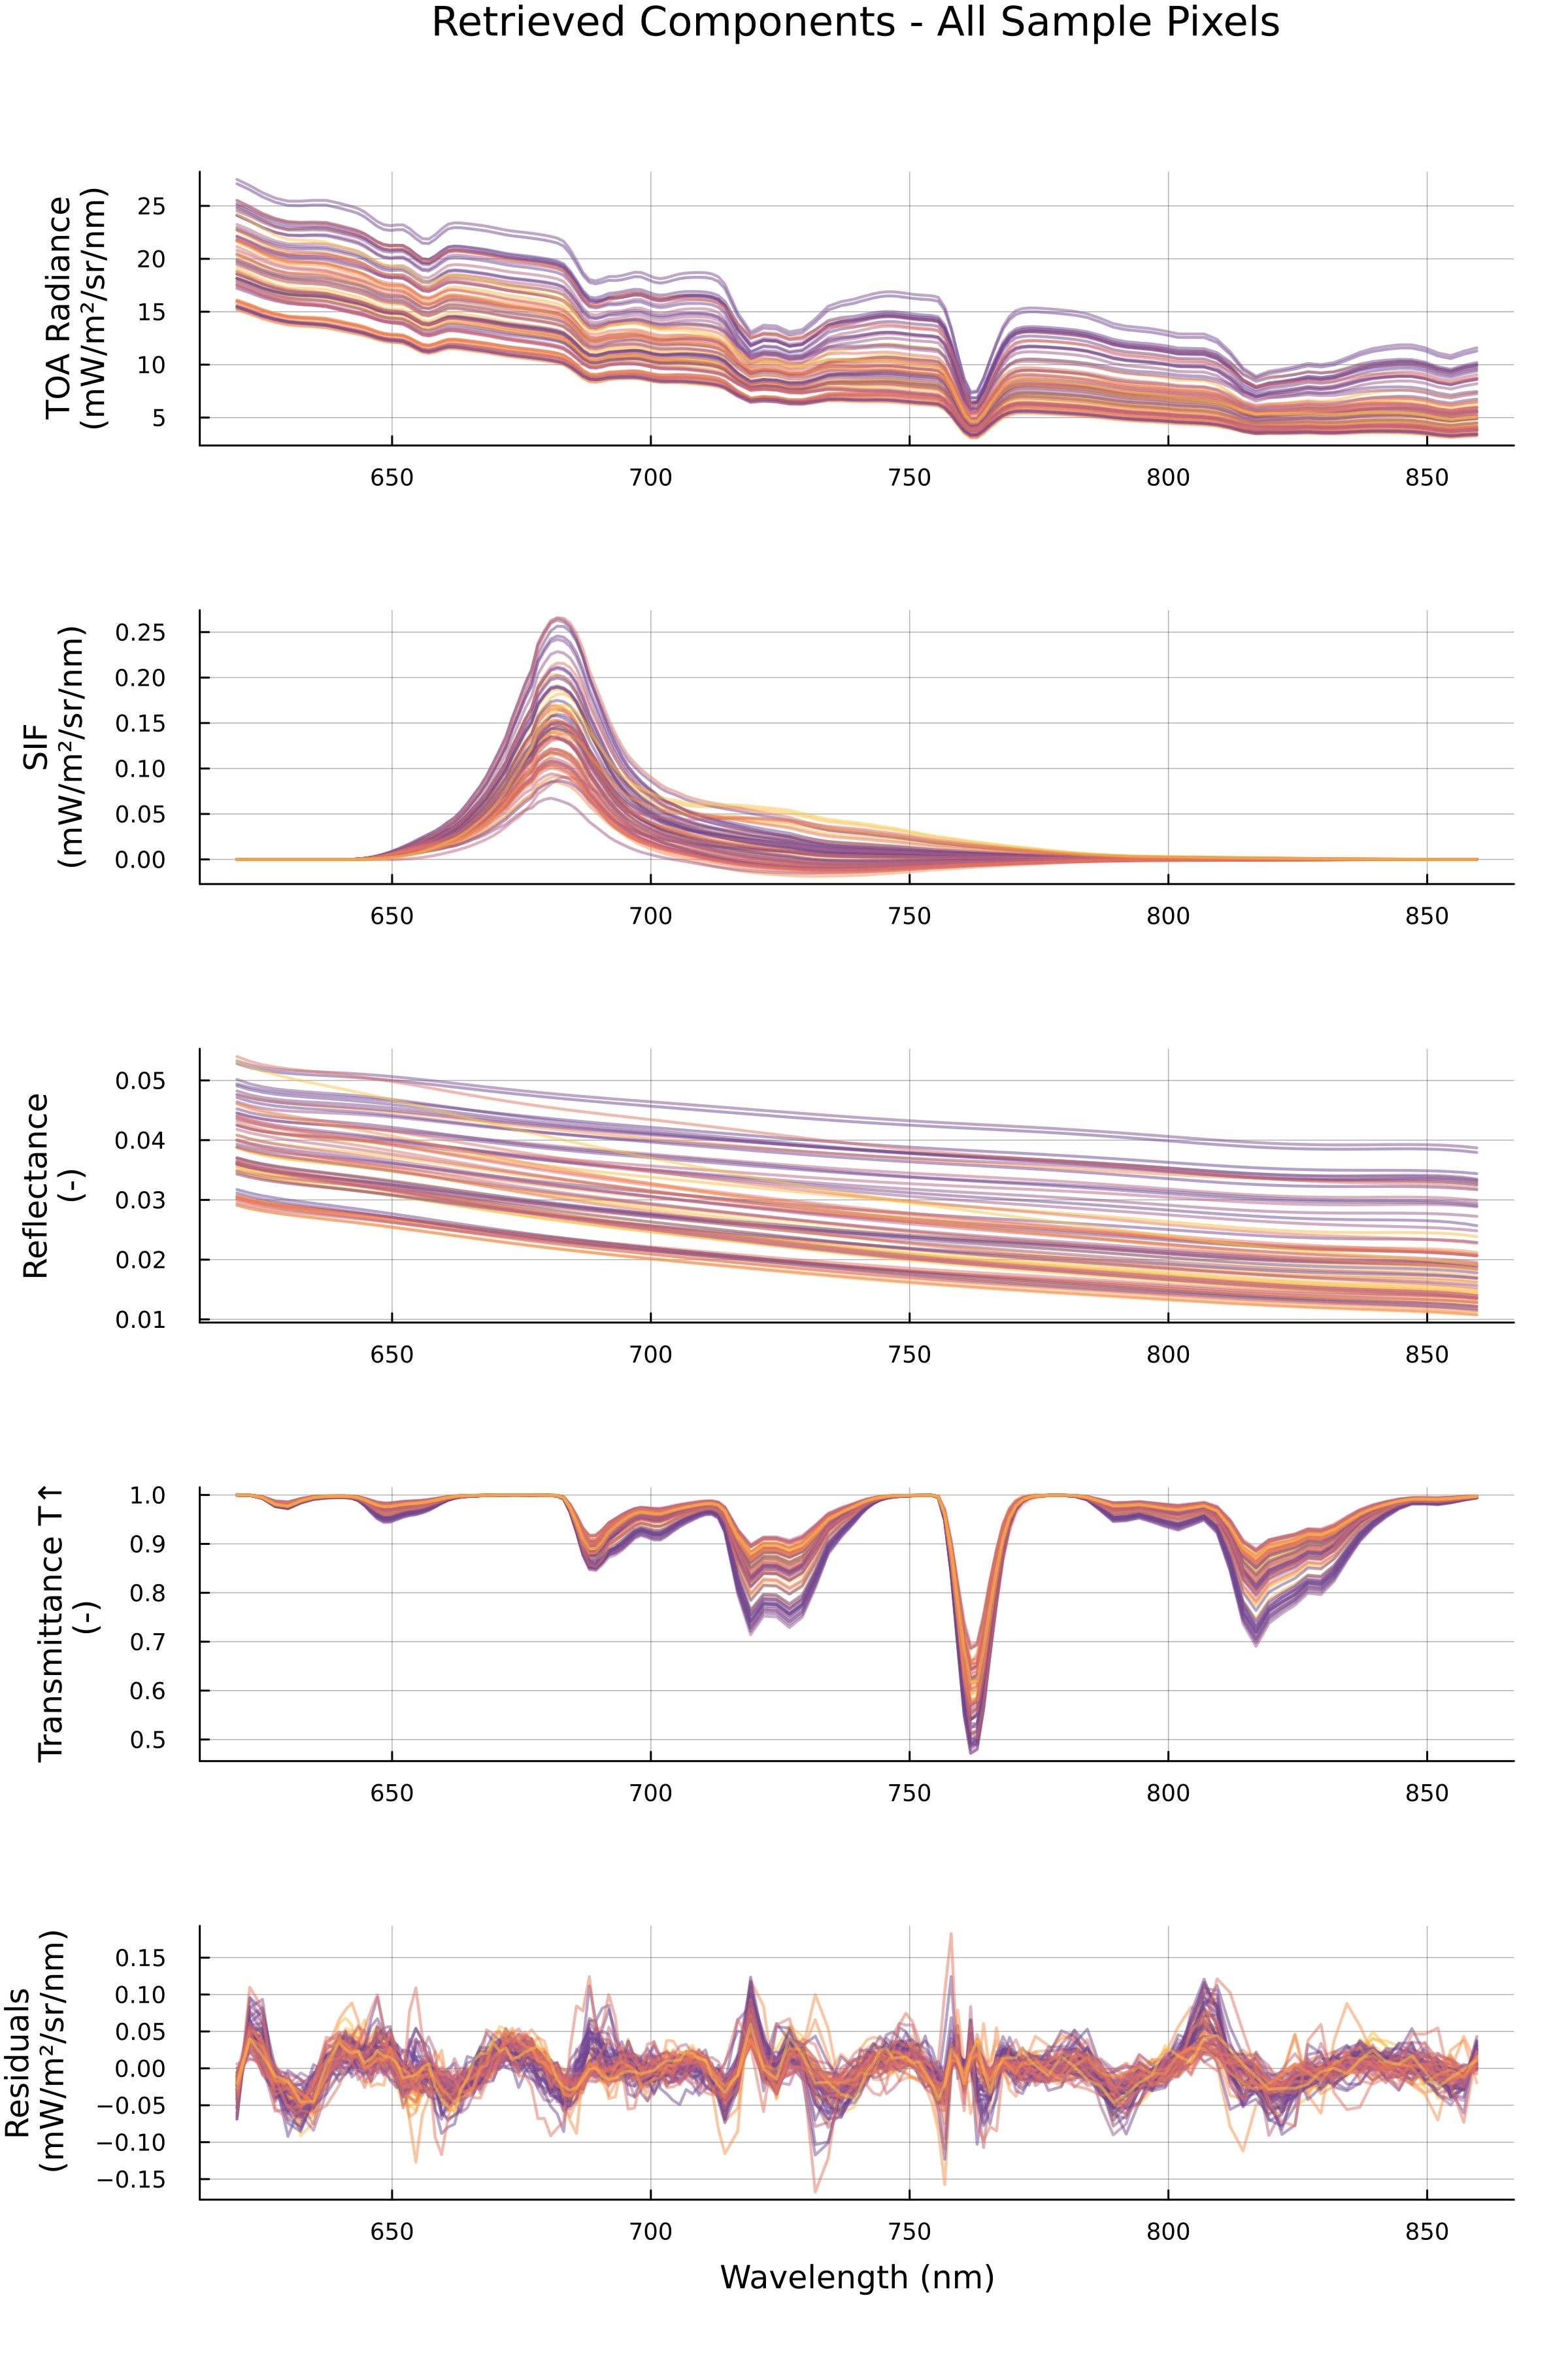

In [92]:
# Visualize spectra of components
# Sample pixels in a regular grid
n_pixels, n_scans = size(components["SIF"], 1), size(components["SIF"], 2)
pixel_step = 80

# Get sample coordinates
sample_pixels = []
for i in 1:pixel_step:n_pixels
    for j in 1:pixel_step:n_scans
        # Check if valid
        if !isnan(components["SIF"][i, j, 1])
            push!(sample_pixels, (i, j))
        end
    end
end

# Draw all sample_pixels with 5 panels
p_all = plot(layout=(5, 1), size=(800, 1200), 
             legend=false,
             dpi=300,
             margin=5Plots.mm)

component_info_all = [
    # ("radiance", "TOA Radiance", :Blues, 1.0),
    # ("SIF", "SIF (mW/m²/sr/nm)", :reds, 1.0),
    # ("reflectance", "Reflectance (ρ)", :viridis, 1.0),
    # ("T1", "Transmittance T↑", :plasma, 1.0),
    # ("residual", "Residuals", :thermal, 1.0)
    ("radiance", "TOA Radiance\n(mW/m²/sr/nm)", :thermal, 1.0),
    ("SIF", "SIF\n(mW/m²/sr/nm)", :thermal, 1.0),
    ("reflectance", "Reflectance\n(-)", :thermal, 1.0),
    ("T1", "Transmittance T↑\n (-)", :thermal, 1.0),
    ("residual", "Residuals\n  (mW/m²/sr/nm)", :thermal, 1.0)
]

for (idx, (key, title, color_scheme, scale)) in enumerate(component_info_all)
    for (i, (px, py)) in enumerate(sample_pixels)
        spectrum = components[key][px, py, :] .* scale
        
        # For residuals, color by vza
        # if key == "residual"
            vza_ij = vza[px, py]
            color = cgrad(color_scheme)[vza_ij / maximum(vza)]
        # else
        #     color = palette(color_scheme, length(sample_pixels))[i]
        # end
        
        plot!(p_all[idx], params.λ, spectrum,
                label="($px, $py)",
                linewidth=1.5,
                alpha=0.5,
                color=color,
                xlabel=(idx == 5 ? "Wavelength (nm)" : ""),
                ylabel=title,
                grid=true,
                gridalpha=0.3,
                )
    end
end

plot!(p_all, plot_title="Retrieved Components - All Sample Pixels",
        plot_titlefontsize=14)

# Save the figure to /home/zhe2/FraLab/PACE_redSIF_PACE/visualize/Figures
# save_path = "/home/zhe2/FraLab/PACE_redSIF_PACE/visualize/Figures/retrieved_components_all_samples$(granule_code).png"
# savefig(p_all, save_path)

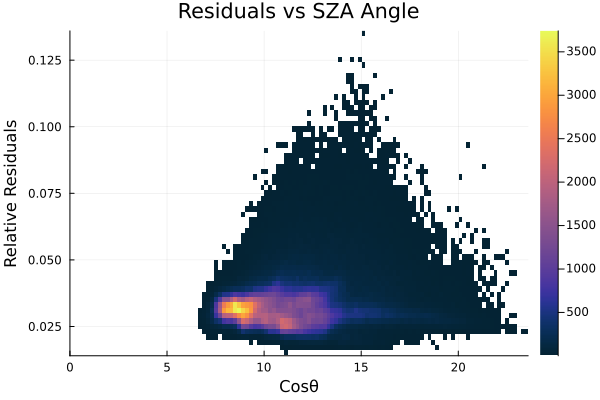

In [85]:
# histogram2d of vza and norm of residuals
residuals = components["residual"]
resuduals_norm = sqrt.(sum(abs2, residuals, dims=3))
residuals_flat = vec(resuduals_norm)
# mean radiance
mean_radiance = mean(components["radiance"], dims=(3))
# relative residual
relative_residuals = residuals ./ (components["radiance"] .+ 1e-6)  # avoid div by zero
relative_residuals_norm = sqrt.(sum(abs2, relative_residuals, dims=3))
relative_residuals_flat = vec(relative_residuals_norm)
# against θ
angle_flat = vec(mean_radiance)
p_hist = histogram2d(angle_flat, relative_residuals_flat,
                    bins=(80, 100),
                    xlims=(0, maximum(angle_flat)),
                    ylims=(-maximum(abs.(residuals_flat)), maximum(abs.(residuals_flat))),
                    xlabel="Cosθ",
                    ylabel="Relative Residuals",
                    title="Residuals vs SZA Angle",
                    color=:thermal,
                    grid=true
                    )

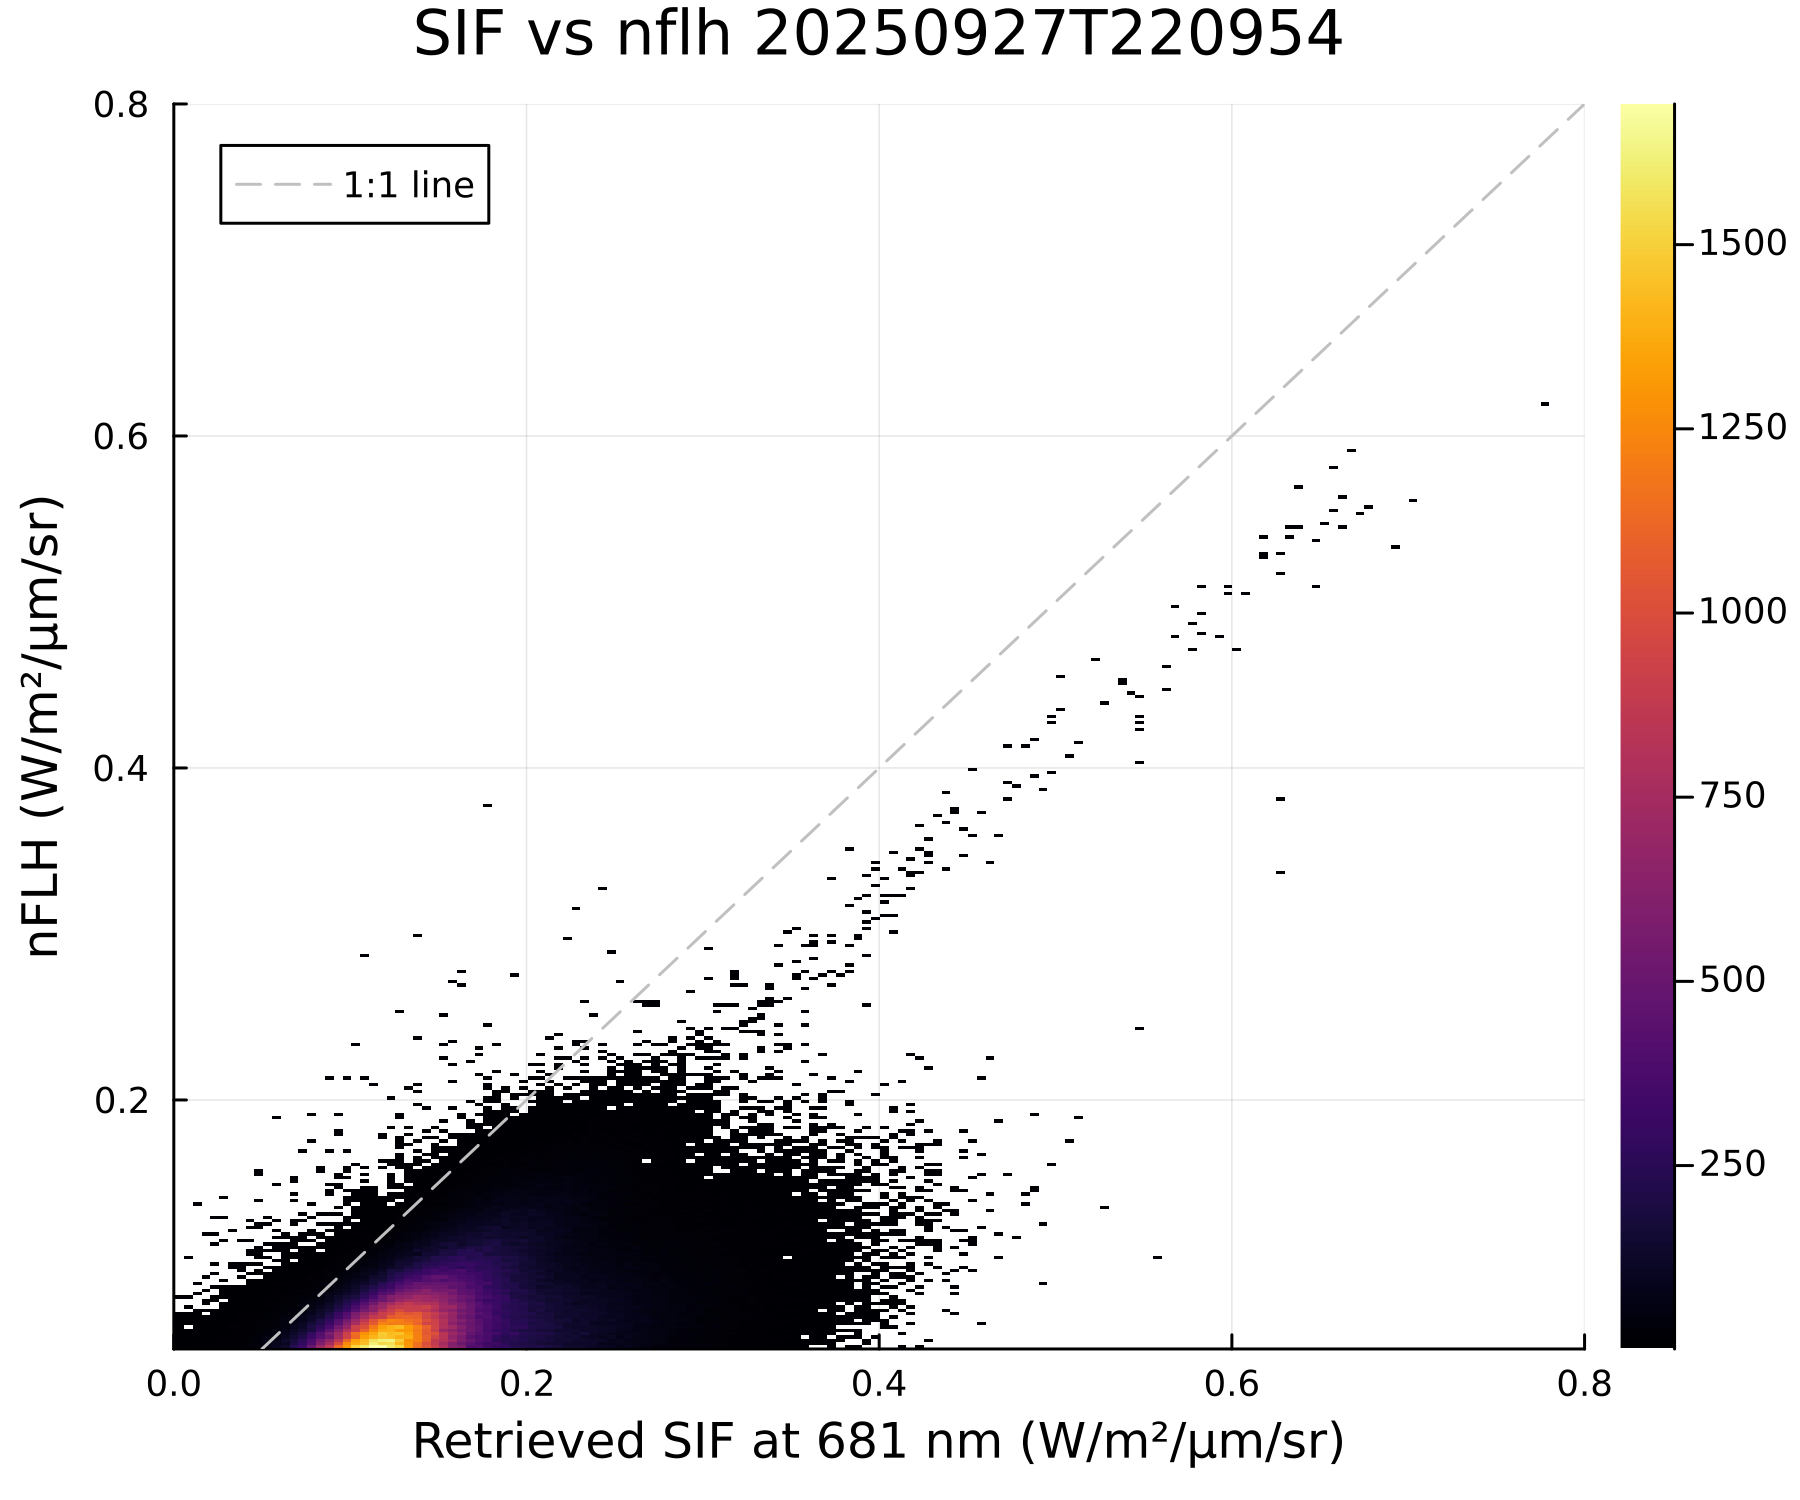

Number of non-missing values in SIF_681: 432865


In [105]:
# stats: non-missing values
println("Number of non-missing values in SIF_681: ", count(!isnan, SIF_681))
# draw histogram2d
min_val_x = 0;
max_val_x = .8;
min_val_y = 0.05;
max_val_y = .8;
p_hist = histogram2d(
    dpi=300,
    SIF_681[:], nflh[:], 
    bins=400, 
    xlims=(min_val_x, max_val_x), ylims=(min_val_y, max_val_y), 
    ylabel="nFLH (W/m²/µm/sr)",
    xlabel="Retrieved SIF at 681 nm (W/m²/µm/sr)",
    title="SIF vs nflh $granule_code",
    size=(600, 500)
    )
# 1:1 line
plot!(p_hist, [min_val_x, max_val_x], [min_val_x, max_val_x], color=:silver, linestyle=:dash, label="1:1 line")
# save figure
save_path = "/home/zhe2/FraLab/PACE_redSIF_PACE/visualize/Figures/SIF_vs_nflh_$(granule_code).png"
savefig(save_path)
# show 
display(p_hist)

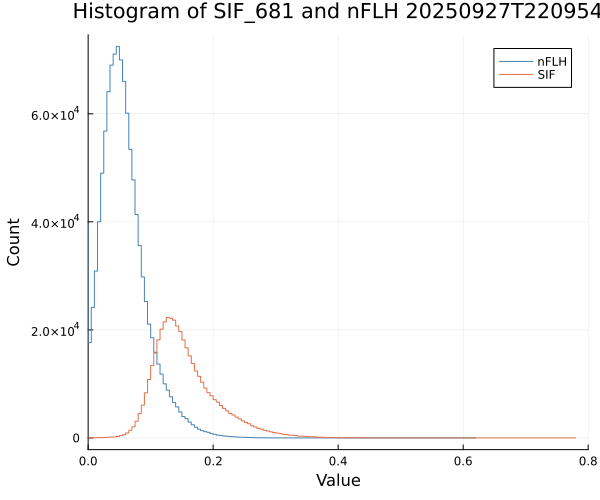

In [104]:
# histgram of nFLH in one plot colored by different colors
# x-axis: value, y-axis: count
histogram(
    nflh[:], 
    bins=200, 
    xlims=(min_val_y, max_val_y), 
    xlabel="nFLH (W/m²/µm/sr)", 
    ylabel="Count", 
    label="nFLH",
    title="Histogram of nFLH $granule_code", 
    size=(600, 500), 
    color=:steelblue
    )
histogram!(
    SIF_681[:],
    bins=200,
    xlims=(min_val_x, max_val_x),
    xlabel="Value",
    ylabel="Count",
    label="SIF",
    title="Histogram of SIF_681 and nFLH $granule_code",
)

In [88]:
granule_code

"20250927T220954"

In [ ]:
# save the retrived SIF as a NetCDF file
output_file = "/home/zhe2/FraLab/PACE_redSIF_PACE/global_fit/gridded_output/retrieved_SIF_681_$(granule_code).nc"
ds_out = Dataset(output_file, "c")
defDim(ds_out, "pixel", size(SIF_681, 1))
defDim(ds_out, "scan", size(SIF_681, 2))
# SIF
var_SIF = defVar(ds_out, "SIF_681", Float32, ("pixel", "scan"))
var_SIF[:, :] = SIF_681
# latitude
var_lat = defVar(ds_out, "latitude", Float32, ("pixel", "scan"))
var_lat[:, :] = ds["latitude"][:, :]
# longitude
var_lon = defVar(ds_out, "longitude", Float32, ("pixel", "scan"))
var_lon[:, :] = ds["longitude"][:, :]
# close the dataset
close(ds_out)
close(ds)


closed Dataset

In [91]:
granule_code

"20250927T220954"